**Modeling growth and propagation of bacterial colonies on flat surfaces: circular colony**

This protocol replicates the main text protocol that simulates colony expansion via mechanical pushing among the growing cells. One of the characteristics of the implemented model is that it undergoes a transition in colony morphology depending on the value of the dense packing parameter. In this protocol, we will choose parameters that result in a round colony. In "branching_colony," we will choose parameters that result in a branching colony.

Additionally,we will show how to generate a simple metabolic model with a single nutrient and a single reaction of biomass growth from uptake of the nutrient.

We will make the layout much smaller than in the paper, however, because it is much faster to run.

In [1]:
import cobra
import cobra.test # for the ijo1366 model
import sys
import numpy as np
sys.path.append("/home/jeremy/Dropbox/work_related/harcombe_lab/segre/COMETS-Python-Toolbox")
import cometspy as c

First, let's make a "toy" model, using functionality of cobrapy. It directly converts extracellular carbon to biomass. 

In [2]:
carbon = cobra.Metabolite("carbon",
                           compartment = "e")
carbon_exch = cobra.Reaction("Carbon_exch",
                            lower_bound = -1.,
                            upper_bound = 1000.)
carbon_exch.add_metabolites({carbon: -1.})
Biomass = cobra.Reaction("Biomass",
                        lower_bound = 0.,
                        upper_bound = 1000.)
Biomass.add_metabolites({carbon: -1.})
toy = cobra.Model("toy")
toy.add_reactions([carbon_exch, Biomass])
#toy.add_reactions([carbon_exch, carbon_transport, Biomass])
toy.objective = "Biomass"
toy.repair()

We can test that the model runs by doing FBA in cobrapy. It should generate as much biomass as the lower bound on carbon_exch.

In [3]:
print(toy.medium)
print(toy.optimize().objective_value)

{'Carbon_exch': 1.0}
1.0


We will now convert this into a COMETS model, set its initial biomass, and set the first set of convection parameters. These are the parameters needed to obtain a circular colony with this toy model. Note that the timestep has to be set very low for this form of biomass spread.

In [33]:
grid_size = 30

toy_comets = c.model(toy)
toy_comets.initial_pop = [int(grid_size / 2),int(grid_size / 2),1.0]
toy_comets.reactions.loc[toy_comets.reactions.EXCH, "LB"] = -1000
toy_comets.add_convection_parameters(packedDensity = 0.5,
                                    elasticModulus = 1.e-4,
                                    frictionConstant = 1.0,
                                    convDiffConstant = 0.0)
toy_comets.add_noise_variance_parameter(20.)

Note: for convection parameters to function,
params.all_params['biomassMotionStyle'] = 'Convection 2D'
must also be set


We make sure that the COMETS model does not consider the biomass reaction an exchange.

In [34]:
toy_comets.reactions.loc[toy_comets.reactions.REACTION_NAMES == "Biomass","EXCH"] = False
toy_comets.reactions.loc[toy_comets.reactions.REACTION_NAMES == "Biomass","EXCH_IND"] = 0
toy_comets.reactions.loc[toy_comets.reactions.REACTION_NAMES == "Biomass", "LB"] = 0

This simulation's layout will be of a single, centered colony on a 100x100 grid. carbon will be spread homogenously.

In [35]:
ly = c.layout([toy_comets])
ly.grid = [grid_size, grid_size]
ly.set_specific_metabolite("carbon", 1.)

The main parameter we need to set is biomassmotionstyle, which must be set to "Convection 2D".  Then, to capture the spatial information, we'll also log biomass (instead of just total biomass). Finally, we'll also adjust a handful of other parameters. These are stored in the dictionary all_params.

In [53]:
p = c.params()

p.set_param("biomassMotionStyle", "Convection 2D")
p.set_param("writeBiomassLog", True)
p.set_param("BiomassLogRate", 100)
p.set_param("maxCycles", 2000)
p.set_param("timeStep", 0.0005)
p.set_param("spaceWidth", 1)
p.set_param("maxSpaceBiomass", 10)
p.set_param("minSpaceBiomass", 0.25e-10)
p.set_param("allowCellOverlap", True)
p.set_param("growthDiffRate", 0)
p.set_param("flowDiffRate", 3e-9)
p.set_param("exchangestyle", "Monod Style")
p.set_param("defaultKm", 0.01)
p.set_param("defaultHill", 1)
p.set_param("defaultVmax", 100)


Now we make a simulation object and run it.  This can take awhile.

In [54]:
sim = c.comets(ly, p)
sim.run() # set delete_files = False to maintain all comets-generated files

    specifically, we cannot find the following libraries at these locations:

library common name 	 expected path
___________________ 	 _____________
gurobi	/opt/gurobi900/linux64/gurobi.jar
junit	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/junit/junit-4.12.jar
hamcrest	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/junit/hamcrest-core-1.3.jar
jogl_all	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/jogl-all.jar
gluegen_rt	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen-rt.jar
gluegen	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen.jar
gluegen_rt_natives	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen-rt-natives-linux-amd64.jar
jogl_all_natives	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/jogl-all-natives-linux-amd64.jar
jmatio	/Dropbox/work_related/ha

Now let's plot the results. we use the helper script "get_biomass_image," which needs the name of the model and the timestep. Then we use matplotlib to display it. 

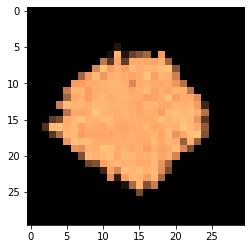

In [56]:
im = sim.get_biomass_image('toy', 2000)
from matplotlib import pyplot as plt
import matplotlib.colors, matplotlib.cm
my_cmap = matplotlib.cm.get_cmap("copper")
my_cmap.set_bad((0,0,0))
plt.imshow(im, norm = matplotlib.colors.LogNorm(), cmap = my_cmap)


We can tile the time series in a simple loop.

In [103]:
big_image = np.zeros((grid_size * 4, grid_size * 5))
im_cycles = np.arange(p.all_params["BiomassLogRate"], p.all_params["maxCycles"] + p.all_params["BiomassLogRate"],
                      p.all_params["BiomassLogRate"])
for i, cycle in enumerate(im_cycles):
    big_image[(grid_size * int(i / 5)):(grid_size + grid_size * int(i / 5)),(grid_size * (i % 5)):(grid_size + grid_size * (i % 5))] = sim.get_biomass_image("toy", cycle)

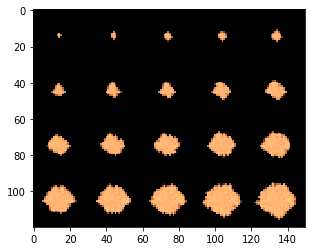

In [105]:
plt.imshow(big_image, norm = matplotlib.colors.LogNorm(), cmap = my_cmap)